### Assignment 01
### Keshav Kumar
### MDS202331

---
## Task
### Build a prototype for sms spam classification
1. in prepare.ipynb write the functions to
 - load the data from a given file path
 - preprocess the data (if needed)
 - split the data into train/validation/test
 - store the splits at train.csv/validation.csv/test.csv
2. in train.ipynb write the functions to
- fit a model on train data
- score a model on given data
- evaluate the model predictions
- validate the model
 - fit on train
 - score on train and validation
 - evaluate on train and validation
 - fine-tune hyper-params using train and validation (if necessary)
- score three benchmark models on test data and select the best one

Use the data
```
https://archive.ics.uci.edu/ml/datasets/sms+spam+collection
```

In [2]:
import os
import requests
import pandas as pd

## 1. Loading the data from a given file path

In [3]:
# Get the data
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip --quiet

# unzip the files
!unzip sms+spam+collection.zip

Archive:  sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
# open the data
with open('SMSSpamCollection', 'r') as f:
    data = f.readlines()

# Reading the data
for line in data[:7]:
  print(line)

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

ham	Even my brother is not like to speak with me. They treat me like aids patent.



## Reading the data as pandas dataframe

In [5]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## 2. Exploratory data analysis
- Data is highly imbalanced
- Data contains duplicates
- The spam messages are longer then ham messages

In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Length of the messages

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: ylabel='Frequency'>

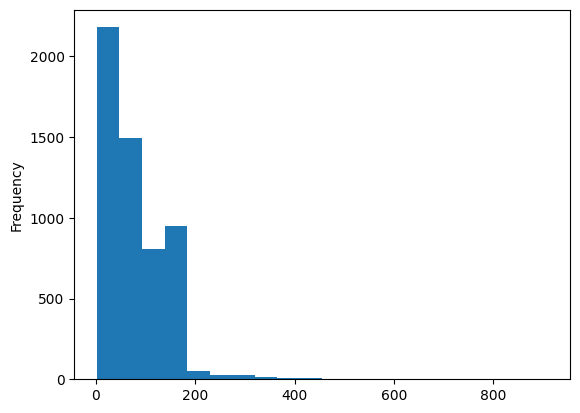

In [ ]:
messages.length.plot(bins=20, kind='hist')


### Distribution of the ham and spam messages

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

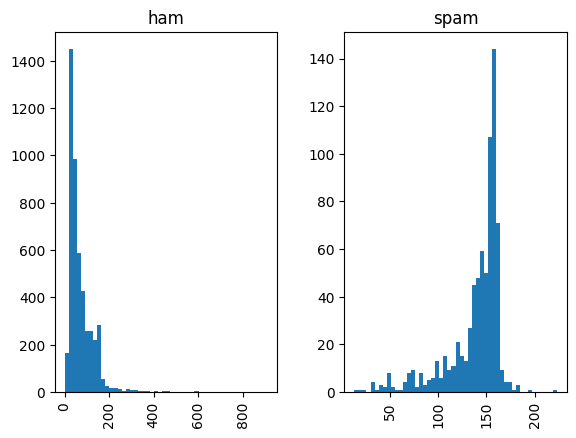

In [ ]:
messages.hist(column='length', by='label', bins = 50)

In [9]:
# The distribution of words in the ham and spam messages
messages.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

## Preprocessing the data

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
import os
import json
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
# cleaning the text
def preprocess_text(text):
    # 1. Case Folding
    text = text.lower()

    # 2. Remove Numbers
    # text = re.sub(r'\d+', '', text)

    # 3. Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 4. Tokenization
    tokens = word_tokenize(text)

    #  5. Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Remove word of length 1
    tokens = [word for word in tokens if len(word) > 1]

    # 7. Remove Extra Whitespace and join tokens back to string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [13]:
# Applying the preprocessing step
messages['message'] = messages['message'].apply(preprocess_text)
messages.head()

,label,message,length
0,ham,go until jurong point crazy available only in ...,111
1,ham,ok lar joking wif oni,29
2,spam,free entry in wkly comp to win fa cup final tk...,155
3,ham,dun say so early hor already then say,49
4,ham,nah dont think he goes to usf he lives around ...,61


In [14]:
# Drop duplicates rows
messages.drop_duplicates(inplace=True)
messages.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4514.0   70.913602  56.724942   2.0   34.0   53.0   91.0  910.0
spam    652.0  137.703988  29.844242  13.0  132.0  148.0  157.0  223.0

## Splitting train, test and validation data
Splitting the dataset into training (70%), validation (15%), and testing (15%) sets. Using stratified splitting to maintain the class balance in each set.

In [15]:
X = messages['message']
y = messages['label']

# Initial train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train set: {y_train.value_counts()}")
print(f"Validation set: {y_val.value_counts()}")
print(f"Test set: {y_test.value_counts()}")


Train set: label
ham     3160
spam     456
Name: count, dtype: int64
Validation set: label
ham     677
spam     98
Name: count, dtype: int64
Test set: label
ham     677
spam     98
Name: count, dtype: int64


## Saving train, test and validation data

In [17]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('/content/Dataset/train.csv', index=False)

test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('/content/Dataset/test.csv', index=False)

val_data = pd.concat([X_val, y_val], axis=1)
val_data.to_csv('/content/Dataset/val.csv', index=False)